## Przygotowanie danych do analizy portfelowej
Dobieramy spółki: PKN Orlen, PZU, KGHM, PEKAO (z zubrem), LPP, CD Projekt, CCC, JSW, Grupa Polsat

Pobieramy dane wykorzystując bibliotekę yfinance i pozostawiając jedynie kolumnę 'Close'

Usuwamy brakujące dane 

Obliczamy logarytmiczne stopy zwrotu

Dzielimy próbkę na train i test

In [303]:
import pandas as pd
import numpy as np
import yfinance as yf

tickers = ["PKN.WA", "PKO.WA", "PZU.WA", "KGH.WA", "PEO.WA", "LPP.WA", "CDR.WA", "CCC.WA", "JSW.WA", "CPS.WA"]  # przykładowy koszyk

data = yf.download(tickers, start="2015-01-01", end="2025-01-01", auto_adjust=True)["Close"]
data = data.dropna()

# log-zwroty dzienne
rets = np.log(data / data.shift(1)).dropna()

# podział na train / test
rets_train = rets[rets.index < "2023-01-01"]
rets_test  = rets[rets.index >= "2023-01-01"]

[*********************100%***********************]  10 of 10 completed


## Przygotowujemy dane średniego zwrotu i odchylenia
Obliczamy średnioroczny zwrot i annualizujemy

Obliczamy macierz wariancji-kowariancji i annualizujemy

Skalowanie przez 252 wynika z założenia, że dane są dzienne i chcemy roczne parametry

n = liczba analizowanych spółek

In [304]:
mu = rets_train.mean() * 252
sigma = rets_train.cov() * 252
n = len(mu)

## Tworzymy funkcję szacującą portfel o najniszej wariancji przy danej oczekiwanej stopie zwrotu
Korzystamy z biblioteki cvxpy do optymalizacji

Definiujemy problem jako minimalizację (cp.Minimize) wyrazenia $x^\top \Sigma\, x$ definiowanego jako cp.quad_form(x, sigma_np)

Następnie definiujemy ograniczenia (constraints)

In [305]:
import cvxpy as cp
import numpy as np

sigma_np = sigma.values #zmiana formatu na numpy
diag_np = np.diag(sigma_np)
mu_np = mu.values #zmiana formatu na numpy
ones = np.ones(n) #wektor jedynek

best_idx = np.argmax(mu_np)
w_best = np.zeros(n)
w_best[best_idx] = 1
var_best = float(w_best @ sigma_np @ w_best)

def min_var_for_return(target_ret):
    x = cp.Variable(n) #wektor zmiennych optymalizowanych

    objective = cp.Minimize(cp.quad_form(x, sigma_np))
    constraints = [
        mu_np @ x == target_ret,
        ones @ x == 1,
        x >= 0
    ]

    prob = cp.Problem(objective, constraints)
    prob.solve()

    return np.array(x.value).flatten()

## Tworzymy funkcję szacującą portfel o największej stopie zwrotu przy danej oczekiwanej wariancji
Korzystamy z biblioteki cvxpy do optymalizacji

Definiujemy problem jako maksymalizację (cp.Maximize) wyrazenia $\max \mu^\top x$ definiowanego jako cp.Maximize(mu_np @ x)

Następnie definiujemy ograniczenia (constraints)

Ze względu na wymagania DCP w cvxpy ograniczenie na wariancję zapisano jako nierówność $x^\top \Sigma x \le \sigma^2$. 

In [306]:
def max_return_for_variance(target_var):
    x = cp.Variable(n) #wektor zmiennych optymalizowanych

    objective = cp.Maximize(mu_np @ x)
    constraints = [
        cp.quad_form(x, sigma_np) <= target_var,
        ones @ x == 1,
        x >= 0
    ]

    prob = cp.Problem(objective, constraints)
    prob.solve()

    return np.array(x.value).flatten()

## Portfele o najnizszej wariancji
Tworzymy wektor (target_returns) 100 równomiernie oddalonych od siebie zwrotów mieszczących się pomiędzy najmniejszym średnim zwrotem a największym

Dla kazdego zwrotu obliczamy wagi w portfelu o minimalnej wariancji. Obliczamy jego średni zwrot oraz wariancję

In [307]:
target_returns = np.linspace(mu_np.min(), mu_np.max(), 50)

portfolios_v = []
for r_target in target_returns:
    try:
        w = min_var_for_return(r_target) #wagi dla danego r_t
        port_ret = float(mu_np @ w) #zwroty dla obliczonych wag
        port_var = float(w @ sigma_np @ w) #wariancja dla obliczonych wag
        portfolios_v.append({
            "target": r_target,
            "mu": port_ret,
            "var": port_var,
            "std": np.sqrt(port_var),
            "weights": w
        })
    except Exception as e:
        continue

port_df_min_v = pd.DataFrame([
    {
        "mu": p["mu"],
        "std": p["std"],
        **{ticker: weight for ticker, weight in zip(tickers, p["weights"])}
    }
    for p in portfolios_v
])

port_df_min_v.round(2)

,mu,std,PKN.WA,PKO.WA,PZU.WA,KGH.WA,PEO.WA,LPP.WA,CDR.WA,CCC.WA,JSW.WA,CPS.WA
0,-0.13,0.49,1.00,-0.00,-0.00,-0.00,-0.00,-0.00,0.00,-0.00,0.00,-0.00
1,-0.13,0.46,0.91,-0.00,0.00,-0.00,-0.00,-0.00,0.09,-0.00,0.00,0.00
2,-0.12,0.43,0.83,-0.00,-0.00,-0.00,-0.00,-0.00,0.17,-0.00,-0.00,-0.00
3,-0.11,0.41,0.76,0.00,0.05,0.00,0.00,0.00,0.20,0.00,0.00,0.00
4,-0.10,0.38,0.69,0.00,0.10,0.00,0.00,0.00,0.21,0.00,-0.00,0.00
5,-0.09,0.35,0.62,0.00,0.15,-0.00,-0.00,-0.00,0.23,-0.00,-0.00,-0.00
6,-0.09,0.33,0.55,-0.00,0.20,0.00,0.00,0.00,0.25,0.00,0.00,0.00
7,-0.08,0.31,0.48,-0.00,0.26,-0.00,-0.00,0.00,0.27,-0.00,-0.00,-0.00
8,-0.07,0.29,0.40,0.00,0.31,0.00,0.00,0.00,0.29,0.00,0.00,0.00
9,-0.06,0.27,0.33,0.00,0.36,0.00,0.00,0.00,0.30,-0.00,-0.00,-0.00


## Tworzymy wykres portfeli

Najmniejsze odchylenie:  0.21
Zwrot:  0.03496


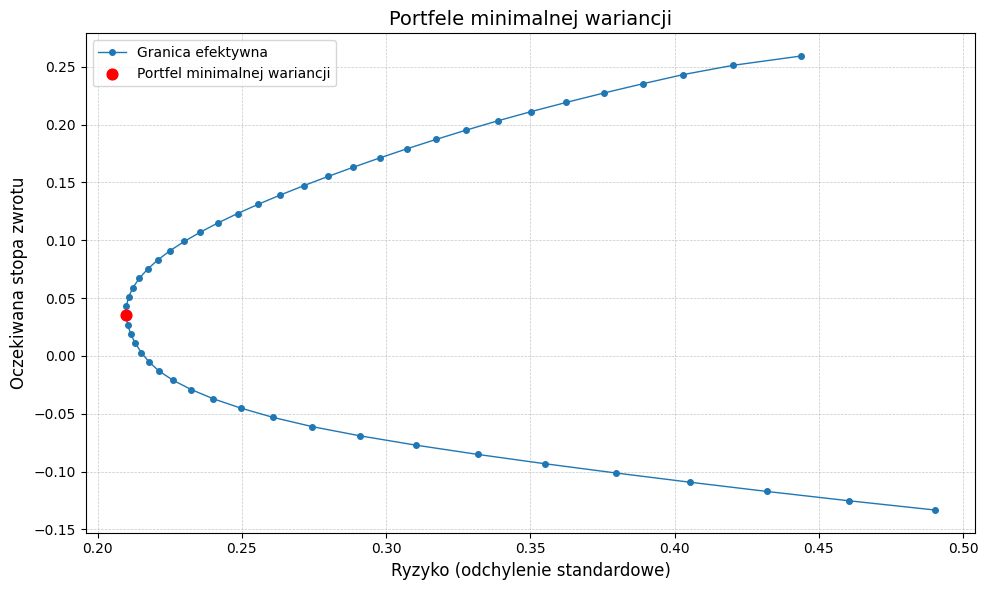

In [308]:
from matplotlib import pyplot as plt

gmv_idx = port_df_min_v['std'].idxmin() #id portfela o minimalnej wariancji
w_gmv = port_df_min_v.loc[gmv_idx, tickers].values
gmv_var = float(w_gmv @ sigma_np @ w_gmv)
gmv_std = port_df_min_v.loc[gmv_idx, 'std']
gmv_mu  = port_df_min_v.loc[gmv_idx, 'mu']

plt.figure(figsize=(10, 6))

plt.plot(port_df_min_v['std'], port_df_min_v['mu'],
         marker='o', markersize=4, linewidth=1,
         label='Granica efektywna')

plt.scatter(gmv_std, gmv_mu,
            color='red', s=60, zorder=5,
            label='Portfel minimalnej wariancji')

plt.title("Portfele minimalnej wariancji", fontsize=14)
plt.xlabel("Ryzyko (odchylenie standardowe)", fontsize=12)
plt.ylabel("Oczekiwana stopa zwrotu", fontsize=12)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.legend()
plt.tight_layout()

print("Najmniejsze odchylenie: ", gmv_std.round(2))
print("Zwrot: ",gmv_mu.round(5))
plt.show()

## Portfele o największej stopie zwrotu
Tworzymy wektor (target_variance) 100 równomiernie oddalonych od siebie wariancji-kowariancji mieszczących się pomiędzy najmniejszą średnią wariancją a największą

Dla kazdej wariancji obliczamy wagi w portfelu o maksymalnej stopie zwrotu. Obliczamy jego średni zwrot oraz wariancję

In [309]:
target_variance = np.linspace(gmv_var, var_best, 50)

portfolios_r = []
for v_target in target_variance:
    try:
        w = max_return_for_variance(v_target) #wagi dla danego r_t
        port_ret = float(mu_np @ w) #zwroty dla obliczonych wag
        port_var = float(w @ sigma_np @ w) #wariancja dla obliczonych wag
        portfolios_r.append({
            "target": v_target,
            "mu": port_ret,
            "var": port_var,
            "std": np.sqrt(port_var),
            "weights": w
        })
    except Exception as e:
        continue

port_df_max_r = pd.DataFrame([
    {
        "mu": p["mu"],
        "std": p["std"],
        **{ticker: weight for ticker, weight in zip(tickers, p["weights"])}
    }
    for p in portfolios_r
])

port_df_max_r.round(2)

,mu,std,PKN.WA,PKO.WA,PZU.WA,KGH.WA,PEO.WA,LPP.WA,CDR.WA,CCC.WA,JSW.WA,CPS.WA
0,0.04,0.21,0.0,0.11,0.33,0.00,0.0,0.03,0.05,0.15,0.04,0.28
1,0.07,0.22,0.0,0.22,0.26,0.01,0.0,0.05,0.00,0.18,0.02,0.27
2,0.09,0.22,0.0,0.26,0.22,0.02,0.0,0.05,0.00,0.18,0.00,0.26
3,0.10,0.23,0.0,0.30,0.19,0.03,0.0,0.06,0.00,0.19,0.00,0.24
4,0.11,0.24,0.0,0.33,0.17,0.04,0.0,0.06,0.00,0.19,0.00,0.22
5,0.12,0.24,0.0,0.36,0.14,0.05,0.0,0.06,0.00,0.19,0.00,0.20
6,0.13,0.25,0.0,0.38,0.12,0.05,0.0,0.06,0.00,0.19,0.00,0.19
7,0.13,0.26,0.0,0.40,0.10,0.06,0.0,0.06,0.00,0.20,0.00,0.18
8,0.14,0.26,0.0,0.42,0.09,0.06,0.0,0.07,0.00,0.20,0.00,0.17
9,0.14,0.27,0.0,0.44,0.07,0.07,0.0,0.07,0.00,0.20,0.00,0.16


## Tworzymy wykres portfeli

Najmniejsze odchylenie:  0.44
Zwrot:  0.2592


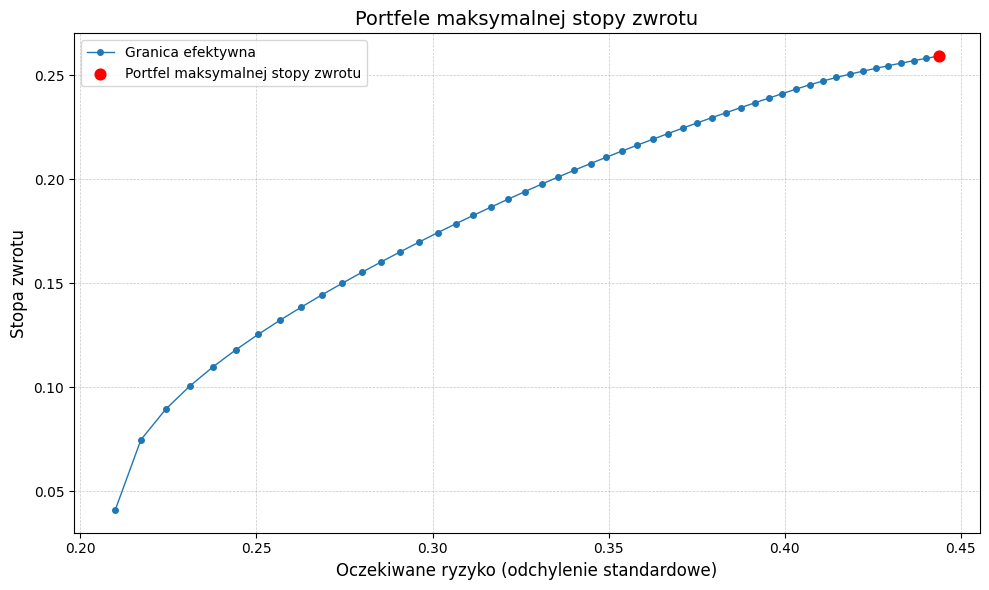

In [310]:
gmr_idx = port_df_max_r['mu'].idxmax() #id portfela o największej stopie zwrotu
gmr_std = port_df_max_r.loc[gmr_idx, 'std']
gmr_mu  = port_df_max_r.loc[gmr_idx, 'mu']

plt.figure(figsize=(10, 6))

plt.plot(port_df_max_r['std'], port_df_max_r['mu'],
         marker='o', markersize=4, linewidth=1,
         label='Granica efektywna')

plt.scatter(gmr_std, gmr_mu,
            color='red', s=60, zorder=5,
            label='Portfel maksymalnej stopy zwrotu')

plt.title("Portfele maksymalnej stopy zwrotu", fontsize=14)
plt.xlabel("Oczekiwane ryzyko (odchylenie standardowe)", fontsize=12)
plt.ylabel("Stopa zwrotu", fontsize=12)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.legend()
plt.tight_layout()

print("Najmniejsze odchylenie: ", gmr_std.round(2))
print("Zwrot: ",gmr_mu.round(5))
plt.show()

## Testujemy portfele o minimalnej wariancji

Bierzemy 3 warianty portfeli do testowania:
- portfel z najmniejszą wariancją, otrzymany z zadania minimalizacji wariancji przy danej oczekiwanej stopie zwrotu,
- portfel z największą stopą zwrotu, otrzymany z zadania minimalizacji wariancji przy danej oczekiwanej stopie zwrotu,
- portfel gdzie wszystkie wagi są równe.

Test portfeli odbywa się w latach 2023-2025

In [311]:
w_eq = np.repeat(1/n, n) #równe wagi

p_low_risk = min(portfolios_v, key=lambda p: p["std"]) #portfel o najniszej wariancji
p_high_ret = max(portfolios_v, key=lambda p: p["mu"]) #portfel o największej stopie zwrotu
w_low = p_low_risk["weights"] #wagi portfeli
w_high = p_high_ret["weights"]

In [312]:
def portfolio_performance(weights, rets):
    port_rets = rets @ weights #zwrot z portfela
    cum_ret = (1 + port_rets).prod() - 1 #skumulowany zwrot z portfela
    ann_ret = port_rets.mean() * 252 #średnioroczny zwrot
    ann_vol = port_rets.std() * np.sqrt(252) #średnioroczne odchylenie standardowe
    sharpe = ann_ret / ann_vol #wskaźnik Sharpe
    return {
        "cum_ret": cum_ret,
        "ann_ret": ann_ret,
        "ann_vol": ann_vol,
        "sharpe": sharpe
    }

results = {}

results["low_train"]  = portfolio_performance(w_low, rets_train)
results["low_test"]   = portfolio_performance(w_low, rets_test)

results["high_train"] = portfolio_performance(w_high, rets_train)
results["high_test"]  = portfolio_performance(w_high, rets_test)

results["EQ_train"]   = portfolio_performance(w_eq, rets_train)
results["EQ_test"]    = portfolio_performance(w_eq, rets_test)

pd.DataFrame(results).T.round(2)

,cum_ret,ann_ret,ann_vol,sharpe
low_train,0.11,0.03,0.21,0.17
low_test,0.09,0.07,0.23,0.31
high_train,2.68,0.26,0.44,0.58
high_test,0.30,0.20,0.38,0.54
EQ_train,0.09,0.04,0.25,0.17
EQ_test,0.24,0.13,0.22,0.60


## Testujemy portfele o maksymalnej stopie zwrotu

Bierzemy 3 warianty portfeli do testowania:
- portfel z najmniejszą wariancją, otrzymany z zadania maksymalizacji stopy zwrotu przy danej oczekiwanej wariancji,
- portfel z największą stopą zwrotu, otrzymany z zadania maksymalizacji stopy zwrotu przy danej oczekiwanej wariancji,
- portfel gdzie wszystkie wagi są równe.

Test portfeli odbywa się w latach 2023-2025

In [313]:
p_low_risk = min(portfolios_r, key=lambda p: p["std"])
p_high_ret = max(portfolios_r, key=lambda p: p["mu"])
w_low = p_low_risk["weights"]
w_high = p_high_ret["weights"]

In [314]:
results = {}

results["low_train"]  = portfolio_performance(w_low, rets_train)
results["low_test"]   = portfolio_performance(w_low, rets_test)

results["high_train"] = portfolio_performance(w_high, rets_train)
results["high_test"]  = portfolio_performance(w_high, rets_test)

results["EQ_train"]   = portfolio_performance(w_eq, rets_train)
results["EQ_test"]    = portfolio_performance(w_eq, rets_test)

pd.DataFrame(results).T.round(2)

,cum_ret,ann_ret,ann_vol,sharpe
low_train,0.16,0.04,0.21,0.19
low_test,0.09,0.07,0.22,0.31
high_train,2.68,0.26,0.44,0.58
high_test,0.30,0.20,0.38,0.54
EQ_train,0.09,0.04,0.25,0.17
EQ_test,0.24,0.13,0.22,0.60
